The input is used to train a XGBoost regressor and calculate atom contribution values based on the SHAP values of the features as explained in the below pseudo-code.

The output is given as a list of atom contribution values providing information about how much each atom contributes to the goodness-of-fit.

# First import modules, set seed parameters and import functions

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time, shap
import xgboost as xgb
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import pandas as pd

/home/mrg/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/home/mrg/envs/python37/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='

In [2]:
np.random.seed(14)

In [3]:
def Load_starting_model(starting_model):
    """
    This function loads the structure
    """

    # Read structure and divide it into two lists: Atoms we want to iterate (W) and atoms we do not iterate (O)
    struct=[]
    with open(starting_model, 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            if len(sep_line)==4: #  tillader andre informationer i xyz filen some ikke skal laeses
                struct.append(sep_line)
    elements=np.array(struct)[:,0]
    xyz=(np.array(struct)[:,1:].astype(float))
    
    return elements, xyz


def Import_Dataset(FileName) -> np.array:
    """
    This function loads a catalogue of structures with their corresponding Rwp values and split the dataset 
    into a training set and validation set with features and labels.
    """
    # load data
    dataset = np.loadtxt(FileName, delimiter=" ", skiprows=0)
    dataset_original = dataset.copy()

    # Split into training and validation set
    dataset_train = dataset[:int(len(dataset)*0.8)]
    dataset_val = dataset[int(len(dataset)*0.8):len(dataset)]
    
    # split data into features (X) and labels (y)
    X_train = dataset_train[:,2:len(dataset)+1]
    y_train = dataset_train[:,1]
    X_val = dataset_val[:,2:len(dataset)+1]
    y_val = dataset_val[:,1]
    
    print(f"Number of Training Data: {len(y_train)}")
    print("Number of Validation Data: {len(y_val)}")
        
    return X_train, y_train, X_val, y_val

def Validate_XGBoost(model, X_val, y_val):
    """
    Function to validate the performance of the XGBoost algorithm on a validation set
    """
    print ("Giving an estimate of the accuracy of the model")
    xgb_val = xgb.DMatrix(X_val, y_val)
    y_pred_val = model.predict(xgb_val)
    rmse = mean_squared_error(y_val, y_pred_val)
    print(f"RMSE: {rmse:f}")
    return rmse

def DecisionTree_CrossValidation(learning_rate, max_depth, data, targets):
    """
       Decision Tree cross validation.
       Fits a Decision Tree with the given paramaters to the target 
       given data, calculated a CV accuracy score and returns the mean.
       The goal is to find combinations of max_depth, min_samples_leaf 
       that maximize the accuracy
    """
    
    estimator = xgb.XGBRegressor(random_state=0, 
                                       learning_rate = learning_rate,
                                       max_depth=max_depth,
                                       objective='reg:squarederror') 
    
    cval = cross_val_score(estimator, data, targets, cv=3)
    return cval.mean()


def optimize_DecisionTree(data, targets, pars, n_iter=5):
    """
    Apply Bayesian Optimization to Decision Tree parameters.
    """
    
    def crossval_wrapper(learning_rate, max_depth):
        """
           Wrapper of Decision Tree cross validation. 
           Notice how we ensure max_depth, min_samples_leaf 
           are casted to integer before we pass them along.
        """
        accuracy_mean = DecisionTree_CrossValidation(learning_rate = learning_rate,
                                       max_depth=int(max_depth), 
                                       data=data, targets=targets)
        
        return accuracy_mean
    
    optimizer = BayesianOptimization(f=crossval_wrapper, pbounds=pars, 
                                     random_state=0, verbose=2)
    optimizer.maximize(init_points=4, n_iter=n_iter)

    return optimizer

def train_w_earlyStop(X_train, y_train, learning_rate, max_depth, n_estimators, n_jobs, gamma, min_child_weight, base_score, seed, early_stop, xgb_model=None):
    """
    Train a XGBoost model using the given parameters. The training will run until the early stop criteria is
    fulfilled or 5000 epochs are run. The loss curve and values is saved.
    """
    start_time = time.perf_counter()

    xgb_params = {}
    xgb_params['learning_rate'] = learning_rate
    xgb_params['objective'] = 'reg:squarederror' # Default
    xgb_params['max_depth'] = max_depth
    xgb_params['n_estimators'] = n_estimators
    xgb_params['n_jobs'] = n_jobs
    xgb_params['gamma'] = gamma
    xgb_params['min_child_weight'] = min_child_weight
    xgb_params['eval_metric'] = ['mae']
    xgb_params['base_score'] = base_score
    xgb_params['seed'] = seed
    xgb_params['verbosity'] = 0
    epochs = 5000

    store = {}
    xgb_train = xgb.DMatrix(X_train, y_train)
    xgb_val = xgb.DMatrix(X_val, y_val)
    evallist = [(xgb_train,'train'),(xgb_val, 'val')]
    model = None

    model = xgb.train(xgb_params, xgb_train, epochs, evallist, evals_result=store, verbose_eval=0, early_stopping_rounds=early_stop, xgb_model=model)
    print ("Training using the best parameters")
    print(f"Total execution time: {time.perf_counter()-start_time:.3f} s")
    print ("Training succeeded")
    
    # Save Loss
    loss_results = pd.DataFrame(store)
    loss_results.to_csv("LossCurve.csv")

    # Plot Loss
    test_score = store['val']['mae']
    train_score = store['train']['mae']
    plt.plot(range(len(test_score)), test_score, "c", label="Val")
    plt.plot(range(len(train_score)), train_score, "orange", label="Train")
    plt.xlabel("Epochs")
    plt.ylabel("MAE Loss")
    plt.legend()
    plt.savefig("LossCurve.png")
    return model, store

def shap_essential_figure(model, X_train, saveResults):
    """
    Function that takes a XGBoost model, a training set and calculates SHAP values of each features in the 
    training set. Afterwards, it saves a SHAP summary plot
    """
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_train) 
    # Make SHAP summary plot
    shap.summary_plot(shap_values[:,1:], X_train[:,1:], feature_names=["Atom #"+str(i) for i in range(1,X_train.shape[1])], color_bar_label="Feature Value (Low: Atom Removed, High: Atom Not Removed)", show=False, max_display=X_train.shape[1]) # to plot these explanations
    plt.savefig(saveResults + "SHAP_values.png", dpi=600, format = "png", bbox_inches='tight')
    return explainer, shap_values

def calculate_atomContributionValue(shap_values, X_train, saveResults):
    """
    Calculate atom contribution value list from the result array
    """
    
    # Define AtomContributionValues vector
    AtomContributionValues = []
    for i in range(X_train.shape[1]):
        # We are not interested in the number of atoms in this regi
        if i == 0:
            AtomContributionValues.append(0)
        else:
            Keep_atoms = np.mean((shap_values[np.where(X_train[:,i] == 1),i]))
            Remove_atoms = np.mean((shap_values[np.where(X_train[:,i] == 0),i]))
            AtomContributionValues.append(0.5*Keep_atoms - 0.5*Remove_atoms)
    
    # Normalise the AtomContributionValues
    amin, amax = min(AtomContributionValues), max(AtomContributionValues)
    AtomContributionValues = (AtomContributionValues - amin) / (amax - amin)
    AtomContributionValues_ph = AtomContributionValues.copy()
    AtomContributionValues_ph.sort()

    # Define colormap of viridis.reverse
    norm = mpl.colors.Normalize(vmin=AtomContributionValues_ph[round((len(AtomContributionValues))/10)], vmax=AtomContributionValues_ph[-round((len(AtomContributionValues))/10)])
    cmap = mpl.cm.cividis_r
    m = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
    
    # Save results to file
    f = open(saveResults+"AtomContributionValues.txt", "w")
    f.write("\nAtom contribution are calculated to: \n")
    for i in range(len(AtomContributionValues)):
        f.write(f"Atom #{i+1}:  {AtomContributionValues[i]}  Colorcode:  {mpl.colors.rgb2hex(m.to_rgba(AtomContributionValues[i]))}\n")
    
    return m, AtomContributionValues

def Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, saveResults, threshold):
    """
     Output a crystalmaker file to visualize the results
    """
    CrystalMaker = open(saveResults+'_CrystalMaker.cmtx', 'w')

    CrystalMaker.write("MOLE  CrystalMaker molecule format\n")
    CrystalMaker.write("TITL  Molecule\n\n")
    CrystalMaker.write("! Model type\n")
    CrystalMaker.write("MODL  1\n\n")

    CrystalMaker.write("! Depth fading settings\n")
    CrystalMaker.write("DCUE  1.000000 0.212899 0.704686\n\n")

    CrystalMaker.write("! Colour definitions:\n")
    CrystalMaker.write("TYPE\n")

    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumMetals:
            CrystalMaker.write(element + str(iter+1) + " 1.32 ")
            rgb = m.to_rgba(AtomContributionValues[iter])[:-1]
        else:
            CrystalMaker.write(element + str(iter+1) + " 0.66 ")
            rgb = mpl.colors.to_rgb("#FF0000")
        # write the color codes
        CrystalMaker.write(f"{rgb[0]} {rgb[1]} {rgb[2]}\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("! Bond Specifications\n")
    
    # Assign bonds between the atoms
    for iter, element in enumerate(elements):
        if iter < NumMetals:
            NI_elements = np.delete(np.unique(elements), np.where(np.unique(elements) == element)[0])
            for NI_element in NI_elements:
                CrystalMaker.write("BMAX " + element + " " + str(NI_element) + "  " + str(threshold))
                CrystalMaker.write("\n")
    
    CrystalMaker.write("\n")
    CrystalMaker.write("! Atoms list\n")
    CrystalMaker.write("ATOM\n")
    
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        #if iter < NumMetals:
        CrystalMaker.write(f"{element} {element}{iter+1} {xyz[iter][0]} {xyz[iter][1]} {xyz[iter][2]}\n")
        #else:
            # there is no difference?
        #    CrystalMaker.write(f"{element} {element}{iter+1} {xyz[iter][0]} {xyz[iter][1]} {xyz[iter][2]}\n")

    CrystalMaker.close()
    
    return None

In [4]:
def Make_VestaFile(elements,
                   xyz, 
                   AtomContributionValues, 
                   m, 
                   saveResults="output", 
                   threshold=2.5
                  ) -> None:
    """
     Vesta output format from 22.06.2022 
     https://colab.research.google.com/github/AndySAnker/ML-MotEx/blob/main/ML_MotEx_Colab.ipynb#scrollTo=CIM9y9ECtRdz
    """
    # Read bonds and colors of all atoms
    bonding = []
    with open("ML-MotEx/util/Bonding.txt", 'r') as fi:
        for line in fi.readlines():
            sep_line=line.strip('{}\n\r ').split()
            bonding.append(sep_line)
    bonding = np.array(bonding)

    # Output a Vesta file to visualize the results
    Vesta = open(saveResults+'_Vesta.vesta', 'w')

    # header info
    Vesta.write("#VESTA_FORMAT_VERSION 3.5.4\n\n\n")
    Vesta.write("MOLECULE\n\n")
    Vesta.write("Title\n")
    Vesta.write("XYZ file\n\n")

    Vesta.write("STRUC\n")
    # Assign coordinates to the atoms
    for iter, element in enumerate(elements):
        #Vesta.write(str(iter+1) + " " + element + " " + element + str(iter+1) + " 1.0000 " + str(xyz[iter][0]) + " " + str(xyz[iter][1]) + " " + str(xyz[iter][2]) + "1" + " -" + "\n")
        Vesta.write(f"{iter+1} {element} {element}{iter+1} 1.0000 {xyz[iter][0]} {xyz[iter][1]} {xyz[iter][2]}1 -\n")
        Vesta.write("0 0 0 0\n")
    Vesta.write("  0 0 0 0 0 0 0\n")

    Vesta.write("SBOND\n")
    # Assign bonds between the atoms
    unique_elements = np.unique(elements)
    for iter, element1 in enumerate(unique_elements):
        for iter, element2 in enumerate(unique_elements):
            if not element1 == element2:
                Vesta.write(str(iter+1) + " " + element1 + " " + element2 + " 0.0 " + str(threshold) + " 0 1 1 0 1 0.25 2 127 127 127\n")
                Vesta.write("0 0 0 0\n")
    
    Vesta.write("SITET\n")
    # Assign colors to all the atoms
    for iter, element in enumerate(elements):
        if iter < NumW:
            rgb1 = int(m.to_rgba(AtomContributionValues[iter])[:-1][0]*255)
            rgb2 = int(m.to_rgba(AtomContributionValues[iter])[:-1][1]*255)
            rgb3 = int(m.to_rgba(AtomContributionValues[iter])[:-1][2]*255)
        else:
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
        Vesta.write(f"{iter+1} {element}{iter+1} {bonding[np.where(bonding == element)[0][0], 1]} {rgb1} {rgb2} {rgb3} {rgb1} {rgb2} {rgb3} 204 0\n")
    Vesta.write("0 0 0 0 0 0\n")
    
    Vesta.write("ATOMT\n")
    done_deal_atoms = []
    for iter, element in enumerate(elements):
        if element not in done_deal_atoms:
            rgb1 = int(float(bonding[np.where(bonding == element)[0][0], 2])*255)
            rgb2 = int(float(bonding[np.where(bonding == element)[0][0], 3])*255)
            rgb3 = int(float(bonding[np.where(bonding == element)[0][0], 4])*255)
            Vesta.write(f"{iter+1} {element} {bonding[np.where(bonding == element)[0][0], 1]} {rgb1} {rgb2} {rgb3} {rgb1} {rgb2} {rgb3} 204\n")
            done_deal_atoms.append(element)
    Vesta.write("0 0 0 0 0 0\n")

    Vesta.close()
    
    return None

# Step 3: Train a XGBoost Regressor to predict the Rwp value based on the structure catalogue
### First define the path of the organized structure catalogue with Rwp values and set range for model optimization. 

It can take a few minutes to train thee XGBoost model. 
N_iter gives a measure of how rounds the model should try to optimize. Set to a low number for a less accurate but fast convergence. 

Number of Training Data: 8000
Number of Validation Data: {len(y_val)}
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  1        |  0.9614   |  0.4842   |  7.722    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  2        |  0.9651   |  0.5219   |  6.359    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  3        |  0.9646   |  0.3966   |  7.167    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  4        |  0.9569   |  0.4063   |  9.134    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  5        |  0.958    |  0.1288   |  2.007    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  6        |  0.9676   |  0.1009   |  5.628    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  7        |  0.9673   |  0.1023   |  5.69     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  8        |  0.9677   |  0.1024   |  5.52     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  9        |  0.9666   |  0.797    |  4.829    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  10       |  0.9674   |  0.1001   |  5.011    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  11       |  0.9672   |  0.1005   |  5.097    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  12       |  0.9676   |  0.1019   |  5.234    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  13       |  0.9676   |  0.101    |  5.217    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  14       |  0.9672   |  0.7981   |  4.945    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  15       |  0.9656   |  0.1046   |  4.963    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  16       |  0.9589   |  0.7979   |  5.164    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  17       |  0.9673   |  0.1004   |  5.888    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  18       |  0.9677   |  0.1022   |  5.608    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  19       |  0.9678   |  0.8      |  2.0      |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  20       |  0.9701   |  0.7968   |  3.074    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  21       |  0.9673   |  0.1008   |  7.703    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  22       |  0.9697   |  0.7965   |  3.151    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  23       |  0.9678   |  0.7981   |  2.977    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  24       |  0.9697   |  0.7972   |  3.01     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  25       |  0.9697   |  0.8      |  3.077    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  26       |  0.97     |  0.7963   |  3.195    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  27       |  0.9689   |  0.7994   |  3.036    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  28       |  0.9697   |  0.7999   |  3.207    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  29       |  0.9689   |  0.7995   |  3.06     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  30       |  0.9676   |  0.7996   |  2.923    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  31       |  0.9668   |  0.1017   |  7.028    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  32       |  0.9693   |  0.7991   |  3.42     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  33       |  0.9689   |  0.7997   |  3.458    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  34       |  0.9689   |  0.7995   |  3.289    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  35       |  0.9676   |  0.7969   |  2.702    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  36       |  0.9694   |  0.7981   |  3.48     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  37       |  0.9696   |  0.7986   |  3.507    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  38       |  0.9697   |  0.7978   |  3.406    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  39       |  0.9697   |  0.7999   |  3.392    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  40       |  0.9697   |  0.7955   |  3.441    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  41       |  0.9692   |  0.7982   |  3.505    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  42       |  0.9701   |  0.7969   |  3.523    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  43       |  0.9687   |  0.7994   |  3.484    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  44       |  0.9691   |  0.7947   |  3.4      |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  45       |  0.9689   |  0.7997   |  3.48     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  46       |  0.9693   |  0.7989   |  3.47     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  47       |  0.9697   |  0.8      |  3.09     |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  48       |  0.9697   |  0.7999   |  3.262    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  49       |  0.9689   |  0.7997   |  3.0      |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  50       |  0.9698   |  0.7975   |  3.464    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  51       |  0.9693   |  0.7988   |  3.534    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  52       |  0.9696   |  0.7976   |  3.448    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  53       |  0.9697   |  0.8      |  3.436    |


`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wan

|  54       |  0.9689   |  0.7994   |  3.368    |
Best parameters were: {'target': 0.9700959848199672, 'params': {'learning_rate': 0.7968455569577488, 'max_depth': 3.073938700780009}}


Pass `evals` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


Training using the best parameters
Total execution time: 9.986 s
Training succeeded
Giving an estimate of the accuracy of the model
RMSE: 0.000335


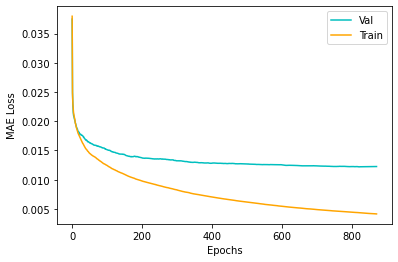

In [5]:
saveFits = "Training_Data/structure_go.txt" # Name of the saved fits file
Min_LR = 0.1 # Minimum learning rate for the XGBoost algorithm
Max_LR = 0.8 # Maximum learning rate for the XGBoost algorithm
Min_Dep = 2 # Minimum max depth for the XGBoost algorithm
Max_Dep = 10 # Maximum max depth for the XGBoost algorithm
n_iter = 50 # Number of iterations for the bayesian optimization model

# Import dataset
X_train, y_train, X_val, y_val = Import_Dataset(saveFits)

# Make a dictionary of parameters we should optimize for the ML algorithm
parameters_BayesianOptimization = {"learning_rate": (Min_LR, Max_LR), #0.1 is default - Boosting learning rate
                                   "max_depth": (Min_Dep, Max_Dep)}  #3 is default - Maximum tree depth for base learners.

# Finding the best parameters for the ML model
BayesianOptimization_func = optimize_DecisionTree(X_train, y_train, parameters_BayesianOptimization, n_iter=n_iter)
print(f"Best parameters were: {BayesianOptimization_func.max}")


# Get best parameters for the ML model and make max depth to an integer
params = BayesianOptimization_func.max['params']
params['max_depth'] = int(params['max_depth'])

#  Define model, train and validate the model and save model
model, store = train_w_earlyStop(X_train, 
                                 y_train, 
                                 n_jobs=1, 
                                 seed=0, 
                                 base_score=0.5, 
                                 n_estimators=100, 
                                 gamma=0, 
                                 min_child_weight=1, 
                                 early_stop=50, 
                                 **params);
Validate_XGBoost(model, X_val, y_val);
model.save_model("ML_algorithms/109725_XGB_model.dat");


# Step 4: Calculate atom contribution values
### Define the path of where the SHAP values and atom contribution values should be saved. 



In [7]:
StemName='output'

# some issue with this, so use ase instead
# Output a CrystalMaker file
#elements, xyz = Load_starting_model(starting_model)

from ase import io
#starting_model = 'Structure_Models/GO_2x2x2.xyz'
starting_model = "Structure_Models/beta-Ga2O3_CollCode83645_2x2x2.xyz"

#Load_starting_model(starting_model)
stru = io.read(starting_model)

xyz = stru.get_positions()
elements = stru.get_chemical_symbols()

threshold=2.5


In [8]:
print(elements)

['Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'Ga', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O',

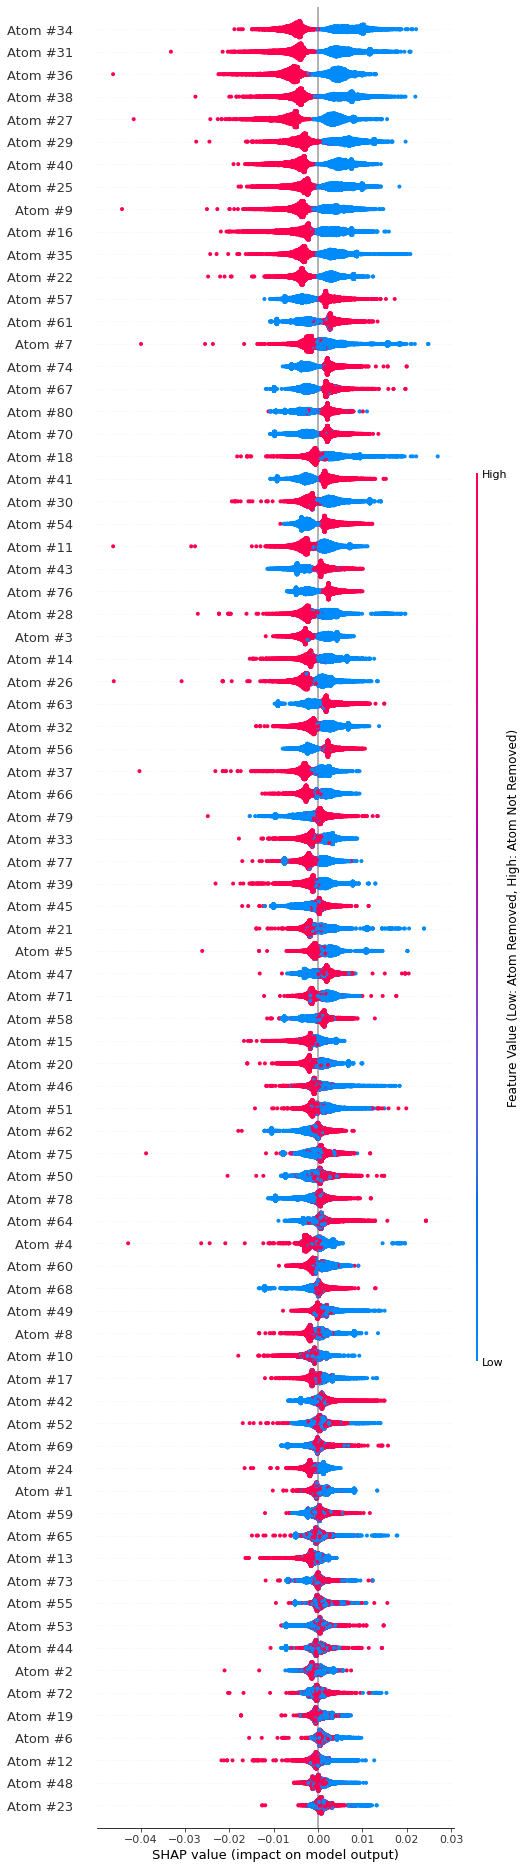

In [9]:


# Calculate SHAP values and save to savePATH.
explainer, shap_values = shap_essential_figure(model, X_train, "./")

# Calculate atom contribution values
m, AtomContributionValues = calculate_atomContributionValue(shap_values, X_train, "./")





In [10]:
NumMetals = 80
Make_CrystalMakerFile(elements, xyz, AtomContributionValues, m, StemName, threshold)